In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import seaborn as sns
import splitfolders
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
cwd = os.getcwd() # Getting current directory

## 1. Import & splitting data

In [3]:
# Splitting data

img_dir = './PokemonData'
data_dir = './input'

if os.path.exists(data_dir): # Creating new "input" folder
    print(f'Data folder {data_dir} exists')
else:
    splitfolders.ratio(img_dir,output = data_dir, seed = 1337, ratio= (0.7, 0.1, 0.2))
    cmd = "splitfolder.ration('"+img_dir+ "', output = 'input', seed = 1337, ratio = (0.7, 0.1, 0.2)"
    cmd = '%s' %cmd
    print(cmd)

Data folder ./input exists


### 1.1. Check the amount of train data

Total number of categories:150
Total number of images in training dataset:4716


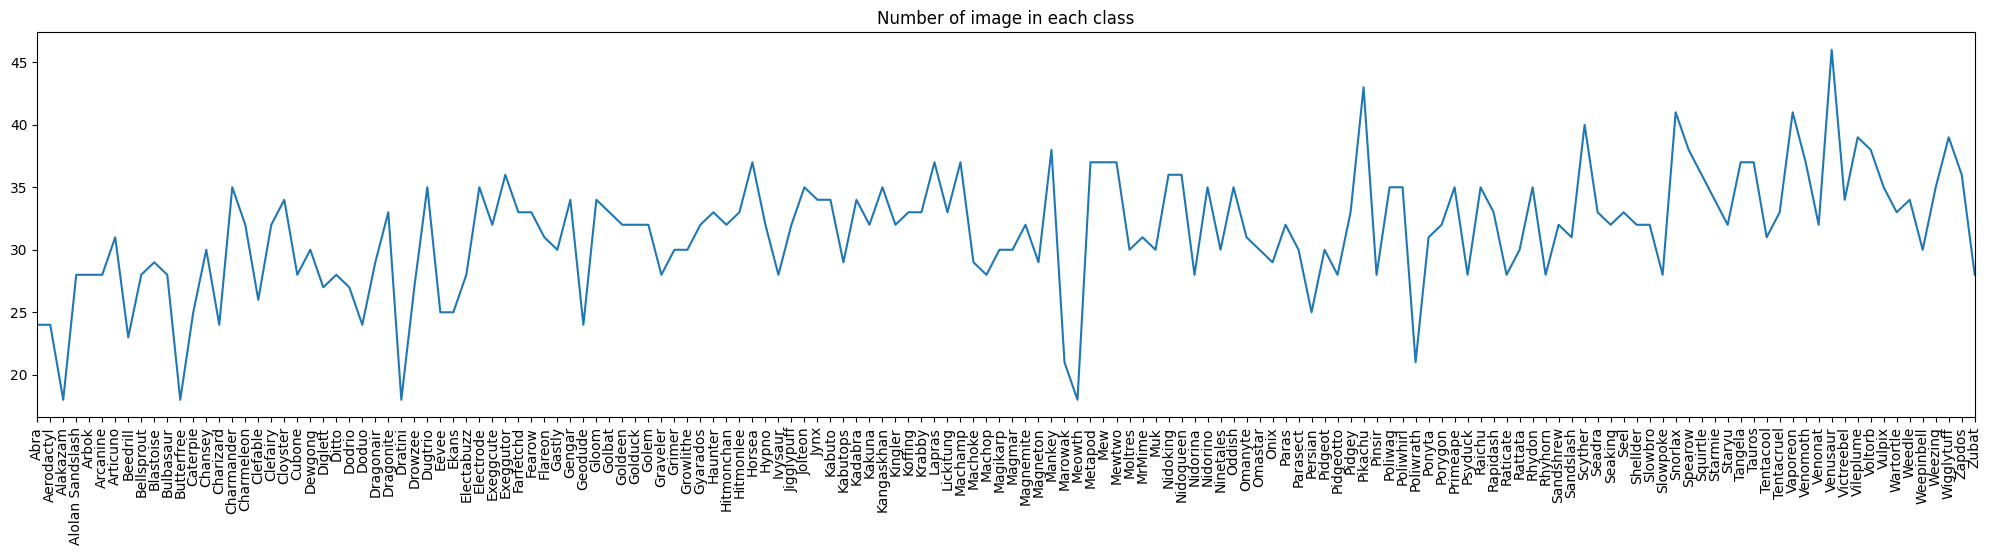

In [4]:
train_dir = data_dir+'/train'
classes = os.listdir(train_dir)
print(f'Total number of categories:{len(classes)}')
counts  ={}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(train_dir,c)))
print(f'Total number of images in training dataset:{sum(list(counts.values()))}')

fig = plt.figure(figsize = (25,5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of image in each class')
plt.xticks(rotation = 90)
plt.margins(x = 0)
plt.show()

In [5]:
batch_size = 4
stats = [(0.485, 0.456, 0.406), (0.229,0.224,0.225)]

epochs = 4 # Difference from the example files

## 2. Define data transformation

In [6]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(stats[0],stats[1])
])

test_transform = transforms.Compose([
    transforms.Resize((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(stats[0],stats[1])
])

### 2.1. Prepare Test and Train sets

Loaders First, split the dataset into different train and test folders using split-folders

In [7]:
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), transform= train_transform)
val_data = datasets.ImageFolder(os.path.join(data_dir,'val'), transform=test_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir,'test'),transform=test_transform)

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

class_name = train_data.classes
num_classes = len(class_name)

print(f'Num classes: {num_classes}')
print(class_name)
print(f'Training images available: {len(train_data)}')
print(f'Test images available: {len(test_data)}')

Num classes: 150
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk'

In [8]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "Cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3050


In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig,ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1,2,0))

def show_batch(dl, nmax = 64):
    for images, _ in dl:
        show_images(images,nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


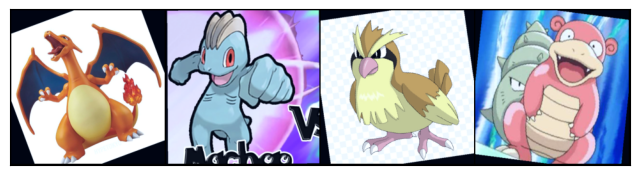

In [10]:
show_batch(train_loader)

## 3. Model_0

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self): #__init__: khai báo các parameters trong class; self:biến để lưu trữ các object, attributes trong class
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,12,3,1)
        self.conv3 = nn.Conv2d(12,24,3,1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,num_classes)
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,28*28*24) # Flatten the output of conv3
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [12]:
model = ConvolutionalNetwork()
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
)

### 3.1. Training

In [13]:
# Define Loss function
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5)

In [14]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')



In [15]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 4.97109699
EPOCH: 0 LOSS: 4.96730709
EPOCH: 0 LOSS: 4.99448872
EPOCH: 0 LOSS: 5.05247593
EPOCH: 0 LOSS: 5.03654099
EPOCH: 0 LOSS: 4.96294022
EPOCH: 0 LOSS: 5.68733120
EPOCH: 0 LOSS: 4.07774115
EPOCH: 0 LOSS: 4.62107611
EPOCH: 0 LOSS: 4.99054003
EPOCH: 0 LOSS: 4.57148361

Validation Accuracy: 0.01951219512195122 minutes
EPOCH: 4 - VAL LOSS:1.1658, VAL_ACCURACY: 0.0195

Duration:0.456 minutes
EPOCH: 1 LOSS: 4.89466619
EPOCH: 1 LOSS: 4.98188019
EPOCH: 1 LOSS: 4.95232439
EPOCH: 1 LOSS: 4.70759583
EPOCH: 1 LOSS: 4.28484821
EPOCH: 1 LOSS: 4.49499178
EPOCH: 1 LOSS: 4.16459274
EPOCH: 1 LOSS: 4.38865566
EPOCH: 1 LOSS: 4.64211512
EPOCH: 1 LOSS: 3.14897633
EPOCH: 1 LOSS: 4.85598183

Validation Accuracy: 0.04878048780487805 minutes
EPOCH: 4 - VAL LOSS:1.0999, VAL_ACCURACY: 0.0488

Duration:0.909 minutes
EPOCH: 2 LOSS: 4.33372593
EPOCH: 2 LOSS: 4.60032701
EPOCH: 2 LOSS: 4.97333956
EPOCH: 2 LOSS: 4.02721214
EPOCH: 2 LOSS: 4.09413910
EPOCH: 2 LOSS: 4.21955681
EPOCH: 2 LOSS: 4.71354103


### 3.2. Testing

In [16]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [17]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
)

In [18]:
test(model, test_loader)

TEST LOSS: 1.0280, accuracy: 0.0979


## ASSIGNMENT

- Assignments 1 to 9 should  start with <font color=red>model_0</font>. In order to make every assignment from 1-13 self-runnable, copy and paster the model0, training and testing code to the code section below and adjust it as necessary to fulfill the assignment
- Assgnments 10-12 start with Resnet 34. Also make each of 10-12 assignments self-runnable
- **Good presentation**: Through the assignments, you should present the results effectively by using the best visualization methods for the given assignments, for example, either text printout, graph, charts, or whatever you think the most appropriate for the results.
- You can modify model_0 for each assignment **as necessary**
- Put your **opinion or analysis or meaning** on the results

- You don't need to implment, for example, Xavier, from scratch. Just use ready-made APIs or Classes of pytorch or python. **You don't need to reinvent the wheels**. If something already out there, then just use it. This principle is true across all the assignment.  So assignment #1 can be implemented with just one or two lines of modification to the model0. All you need to do is to fulfill the assignment. It doesn't matter whether it is done by copying codes from Internet. 

- But DO NOT COPY other student code of this class

### Assignment 1

In [19]:
# Apply Xavier weight initialization
# Apply dropout into model
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        nn.init.xavier_uniform(self.conv1.weight) # Xavier weight initialization
        self.BN1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6,12,3,1)
        self.BN2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12,24,3,1)
        self.BN3 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.BNfc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,256)
        self.BNfc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
    def forward(self,X):
        X = F.relu(self.BN1(self.conv1(X))) # Apply batch normalization into model
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.BN2(self.conv2(X)))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.BN3(self.conv3(X)))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,28*28*24) # Flatten the output of conv3
        X = F.relu(self.BNfc1(self.fc1(X)))
        X = self.dropout1(X)  # Apply drop out into model
        X = F.relu(self.BNfc2(self.fc2(X)))
        X = self.dropout2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

model = ConvolutionalNetwork()
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [20]:
# Apply L2 regularization
# Define Loss function
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [21]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)
                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')



In [22]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 5.30371714
EPOCH: 0 LOSS: 4.39237976
EPOCH: 0 LOSS: 5.13705158
EPOCH: 0 LOSS: 5.67311096
EPOCH: 0 LOSS: 5.77253151
EPOCH: 0 LOSS: 4.98282528
EPOCH: 0 LOSS: 5.06595612
EPOCH: 0 LOSS: 5.49710560
EPOCH: 0 LOSS: 5.56882000
EPOCH: 0 LOSS: 5.01032925
EPOCH: 0 LOSS: 5.90174770

Validation Accuracy: 0.011382113821138212 minutes
EPOCH: 4 - VAL LOSS:1.3774, VAL_ACCURACY: 0.0114

Duration:1.051 minutes
EPOCH: 1 LOSS: 4.74394894
EPOCH: 1 LOSS: 3.20640182
EPOCH: 1 LOSS: 4.97867393
EPOCH: 1 LOSS: 4.84827042
EPOCH: 1 LOSS: 4.50677490
EPOCH: 1 LOSS: 4.60562038
EPOCH: 1 LOSS: 4.27815151
EPOCH: 1 LOSS: 3.88999510
EPOCH: 1 LOSS: 4.80826426
EPOCH: 1 LOSS: 4.00923824
EPOCH: 1 LOSS: 4.71484327

Validation Accuracy: 0.016260162601626018 minutes
EPOCH: 4 - VAL LOSS:1.4032, VAL_ACCURACY: 0.0163

Duration:2.089 minutes
EPOCH: 2 LOSS: 5.48815012
EPOCH: 2 LOSS: 4.32462072
EPOCH: 2 LOSS: 4.34510517
EPOCH: 2 LOSS: 5.14004040
EPOCH: 2 LOSS: 4.85906029
EPOCH: 2 LOSS: 5.16656971
EPOCH: 2 LOSS: 3.5681839

In [23]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [24]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [25]:
test(model, test_loader)

TEST LOSS: 0.8825, accuracy: 0.1538


### Assigment 2

In [26]:
# Apply L2 regularization
# Define Loss function
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001,momentum= 0.9,weight_decay= 1e-5) # L2 regularization and momentum

In [27]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)
                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')



In [28]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 3.26962781
EPOCH: 0 LOSS: 3.89355850
EPOCH: 0 LOSS: 3.46169448
EPOCH: 0 LOSS: 4.51015711
EPOCH: 0 LOSS: 3.58711123
EPOCH: 0 LOSS: 4.25144291
EPOCH: 0 LOSS: 4.01281834
EPOCH: 0 LOSS: 3.30836082
EPOCH: 0 LOSS: 3.40138435
EPOCH: 0 LOSS: 4.57694817
EPOCH: 0 LOSS: 3.16534090

Validation Accuracy: 0.01951219512195122 minutes
EPOCH: 4 - VAL LOSS:1.3975, VAL_ACCURACY: 0.0195

Duration:1.041 minutes
EPOCH: 1 LOSS: 3.78656626
EPOCH: 1 LOSS: 5.17462826
EPOCH: 1 LOSS: 4.26916265
EPOCH: 1 LOSS: 3.81215143
EPOCH: 1 LOSS: 4.65215206
EPOCH: 1 LOSS: 3.60556817
EPOCH: 1 LOSS: 3.89301276
EPOCH: 1 LOSS: 3.94374299
EPOCH: 1 LOSS: 4.87735796
EPOCH: 1 LOSS: 3.37764311
EPOCH: 1 LOSS: 3.97275519

Validation Accuracy: 0.02113821138211382 minutes
EPOCH: 4 - VAL LOSS:1.3988, VAL_ACCURACY: 0.0211

Duration:1.619 minutes
EPOCH: 2 LOSS: 3.80675602
EPOCH: 2 LOSS: 4.37466145
EPOCH: 2 LOSS: 3.85139632
EPOCH: 2 LOSS: 4.92217922
EPOCH: 2 LOSS: 4.81538963
EPOCH: 2 LOSS: 6.38387918
EPOCH: 2 LOSS: 5.44504929


In [29]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [30]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [31]:
test(model, test_loader)

TEST LOSS: 0.8260, accuracy: 0.2057


#### SGD

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [33]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)
                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')



In [34]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 3.87587047
EPOCH: 0 LOSS: 4.36077452
EPOCH: 0 LOSS: 4.90731907
EPOCH: 0 LOSS: 3.96642804
EPOCH: 0 LOSS: 4.08354521
EPOCH: 0 LOSS: 3.32553577
EPOCH: 0 LOSS: 4.61262465
EPOCH: 0 LOSS: 4.04481697
EPOCH: 0 LOSS: 3.67727065
EPOCH: 0 LOSS: 3.70128274
EPOCH: 0 LOSS: 4.44746017

Validation Accuracy: 0.02926829268292683 minutes
EPOCH: 4 - VAL LOSS:1.4211, VAL_ACCURACY: 0.0293

Duration:0.468 minutes
EPOCH: 1 LOSS: 3.64447212
EPOCH: 1 LOSS: 5.12584877
EPOCH: 1 LOSS: 3.94501972
EPOCH: 1 LOSS: 4.00505352
EPOCH: 1 LOSS: 3.63684082
EPOCH: 1 LOSS: 4.29612303
EPOCH: 1 LOSS: 4.15409040
EPOCH: 1 LOSS: 3.83189273
EPOCH: 1 LOSS: 3.35002279
EPOCH: 1 LOSS: 3.44967628
EPOCH: 1 LOSS: 3.64207888

Validation Accuracy: 0.02113821138211382 minutes
EPOCH: 4 - VAL LOSS:1.4287, VAL_ACCURACY: 0.0211

Duration:1.215 minutes
EPOCH: 2 LOSS: 4.25707483
EPOCH: 2 LOSS: 4.12556076
EPOCH: 2 LOSS: 3.30868053
EPOCH: 2 LOSS: 3.82041621
EPOCH: 2 LOSS: 3.55638695
EPOCH: 2 LOSS: 3.89795160
EPOCH: 2 LOSS: 3.77661705


In [35]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [36]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [37]:
test(model, test_loader)

TEST LOSS: 0.8116, accuracy: 0.2144


### Assigment 3

In [38]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

#### Step learning rate annealing

In [39]:
schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma = 0.1)

# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        schedule.step() #Applying step LR annealing
            ## Printing epoch and loss results
        if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)
                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [40]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')


Validation Accuracy: 0.01951219512195122 minutes
EPOCH: 4 - VAL LOSS:1.4775, VAL_ACCURACY: 0.0195

Duration:0.467 minutes

Validation Accuracy: 0.02926829268292683 minutes
EPOCH: 4 - VAL LOSS:1.4663, VAL_ACCURACY: 0.0293

Duration:0.956 minutes

Validation Accuracy: 0.03414634146341464 minutes
EPOCH: 4 - VAL LOSS:1.4724, VAL_ACCURACY: 0.0341

Duration:1.978 minutes

Validation Accuracy: 0.03739837398373984 minutes
EPOCH: 4 - VAL LOSS:1.4683, VAL_ACCURACY: 0.0374

Duration:3.008 minutes


In [41]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)    

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [42]:
test(model, test_loader)

TEST LOSS: 0.7650, accuracy: 0.2550


#### Multi step learning rate annealing

In [43]:
schedule = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,3], gamma = 0.1)

# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        schedule.step() #Applying multi step LR annealing
            ## Printing epoch and loss results
        if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)
                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')


In [44]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')


Validation Accuracy: 0.022764227642276424 minutes
EPOCH: 4 - VAL LOSS:1.4903, VAL_ACCURACY: 0.0228

Duration:1.067 minutes

Validation Accuracy: 0.03577235772357724 minutes
EPOCH: 4 - VAL LOSS:1.4909, VAL_ACCURACY: 0.0358

Duration:2.197 minutes

Validation Accuracy: 0.02926829268292683 minutes
EPOCH: 4 - VAL LOSS:1.4892, VAL_ACCURACY: 0.0293

Duration:3.267 minutes

Validation Accuracy: 0.01788617886178862 minutes
EPOCH: 4 - VAL LOSS:1.4956, VAL_ACCURACY: 0.0179

Duration:4.328 minutes


In [45]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)    

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [46]:
test(model, test_loader)

TEST LOSS: 0.7639, accuracy: 0.2577


#### Exponential learning rate annealing

In [47]:
schedule = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        schedule.step() #Applying Exponential LR annealing
            ## Printing epoch and loss results
        if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)
                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')


In [48]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')


Validation Accuracy: 0.03739837398373984 minutes
EPOCH: 4 - VAL LOSS:1.4762, VAL_ACCURACY: 0.0374

Duration:0.479 minutes

Validation Accuracy: 0.02926829268292683 minutes
EPOCH: 4 - VAL LOSS:1.4727, VAL_ACCURACY: 0.0293

Duration:0.958 minutes

Validation Accuracy: 0.01951219512195122 minutes
EPOCH: 4 - VAL LOSS:1.4853, VAL_ACCURACY: 0.0195

Duration:2.048 minutes

Validation Accuracy: 0.024390243902439025 minutes
EPOCH: 4 - VAL LOSS:1.5039, VAL_ACCURACY: 0.0244

Duration:2.780 minutes


In [49]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)    

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [50]:
test(model, test_loader)

TEST LOSS: 0.7649, accuracy: 0.2610


### Assigment 4

In [51]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        nn.init.xavier_uniform(self.conv1.weight)
        self.BN1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6,12,3,1)
        self.BN2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12,24,3,1,padding = 2,dilation=2) # Using dilation
        self.BN3 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(20184, 512)
        self.BNfc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,256)
        self.BNfc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self,X):
        X = F.relu(self.BN1(self.conv1(X)))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.BN2(self.conv2(X)))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.BN3(self.conv3(X)))
        X = F.max_pool2d(X,2,2)
        X = X.view(X.size(0), -1)
        #if self.fc1 is None: self.fc1 = nn.Linear(X.size(1),512).to(device)
        X = F.relu(self.BNfc1(self.fc1(X)))
        X = self.dropout1(X)
        X = F.relu(self.BNfc2(self.fc2(X)))
        X = self.dropout2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

model = ConvolutionalNetwork()
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20184, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [52]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [53]:
schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma = 0.1)

# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        schedule.step() #Applying step LR annealing
            ## Printing epoch and loss results
        if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)
                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [54]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')


Validation Accuracy: 0.013008130081300813 minutes
EPOCH: 4 - VAL LOSS:1.4261, VAL_ACCURACY: 0.0130

Duration:0.469 minutes

Validation Accuracy: 0.014634146341463415 minutes
EPOCH: 4 - VAL LOSS:1.4144, VAL_ACCURACY: 0.0146

Duration:0.927 minutes

Validation Accuracy: 0.027642276422764227 minutes
EPOCH: 4 - VAL LOSS:1.3934, VAL_ACCURACY: 0.0276

Duration:1.396 minutes

Validation Accuracy: 0.02926829268292683 minutes
EPOCH: 4 - VAL LOSS:1.3794, VAL_ACCURACY: 0.0293

Duration:1.939 minutes


In [55]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (BN2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20184, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [56]:
test(model, test_loader)

TEST LOSS: 0.8945, accuracy: 0.1471


### Assignment 5

#### Applying the 7x7 and 1x1 kernels into the model to see the difference in calculation

In [57]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        nn.init.xavier_uniform(self.conv1.weight) # Xavier weight initialization
        self.BN1 = nn.BatchNorm2d(6)
        self.conv1x1 = nn.Conv2d(6,4,1) # 1x1 conv to reduce channels
        self.conv2 = nn.Conv2d(4,16,7,3) # 7x7 conv to reduce channels
        self.BN2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,24,3,1,padding = 2,dilation=2) # Using dilation
        self.BN3 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(1944, 512)
        self.BNfc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,256)
        self.BNfc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
    def forward(self,X):
        X = F.relu(self.BN1(self.conv1(X))) # Apply batch normalization into model
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv1x1(X))
        X = F.relu(self.BN2(self.conv2(X)))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.BN3(self.conv3(X)))
        X = F.max_pool2d(X,2,2)
        X = X.view(X.size(0),-1) # Flatten the output of conv3
        X = F.relu(self.BNfc1(self.fc1(X)))
        X = self.dropout1(X)  # Apply drop out into model
        X = F.relu(self.BNfc2(self.fc2(X)))
        X = self.dropout2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

model = ConvolutionalNetwork()
model.to(device)


ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1944, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p

In [58]:
# Define Loss function
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5)

In [59]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')


In [60]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 5.61059427
EPOCH: 0 LOSS: 5.19384384
EPOCH: 0 LOSS: 6.31878662
EPOCH: 0 LOSS: 5.58744049
EPOCH: 0 LOSS: 5.17206192
EPOCH: 0 LOSS: 6.32350445
EPOCH: 0 LOSS: 5.03036690
EPOCH: 0 LOSS: 5.60377359
EPOCH: 0 LOSS: 5.36549616
EPOCH: 0 LOSS: 4.59239197
EPOCH: 0 LOSS: 5.27470970

Validation Accuracy: 0.016260162601626018 minutes
EPOCH: 4 - VAL LOSS:1.3508, VAL_ACCURACY: 0.0163

Duration:1.053 minutes
EPOCH: 1 LOSS: 4.93073845
EPOCH: 1 LOSS: 4.39406252
EPOCH: 1 LOSS: 4.03977919
EPOCH: 1 LOSS: 5.60592175
EPOCH: 1 LOSS: 5.08825588
EPOCH: 1 LOSS: 4.59866858
EPOCH: 1 LOSS: 4.73158932
EPOCH: 1 LOSS: 6.47144938
EPOCH: 1 LOSS: 4.16061878
EPOCH: 1 LOSS: 5.16663742
EPOCH: 1 LOSS: 4.83565187

Validation Accuracy: 0.016260162601626018 minutes
EPOCH: 4 - VAL LOSS:1.3463, VAL_ACCURACY: 0.0163

Duration:2.120 minutes
EPOCH: 2 LOSS: 4.57938671
EPOCH: 2 LOSS: 4.33322001
EPOCH: 2 LOSS: 4.24619389
EPOCH: 2 LOSS: 3.85870385
EPOCH: 2 LOSS: 6.11252451
EPOCH: 2 LOSS: 3.14731669
EPOCH: 2 LOSS: 3.8476328

In [61]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [62]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1944, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p

In [63]:
test(model, test_loader)

TEST LOSS: 0.9562, accuracy: 0.1132


### Assigment 6

Let's modify the model so that the model has softmax output inside the model and then apply log and NLLLoss to test whether it really has numerical instability

In [64]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        nn.init.xavier_uniform(self.conv1.weight) # Xavier weight initialization
        self.BN1 = nn.BatchNorm2d(6)
        self.conv1x1 = nn.Conv2d(6,4,1) # 1x1 conv to reduce channels
        self.conv2 = nn.Conv2d(4,16,7,3)
        self.BN2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,24,3,1,padding = 2,dilation=2) # Using dilation
        self.BN3 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(1944, 512)
        self.BNfc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,256)
        self.BNfc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
    def forward(self,X):
        X = F.relu(self.BN1(self.conv1(X))) # Apply batch normalization into model
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv1x1(X))
        X = F.relu(self.BN2(self.conv2(X)))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.BN3(self.conv3(X)))
        X = F.max_pool2d(X,2,2)
        X = X.view(X.size(0),-1) # Flatten the output of conv3
        X = F.relu(self.BNfc1(self.fc1(X)))
        X = self.dropout1(X)  # Apply drop out into model
        X = F.relu(self.BNfc2(self.fc2(X)))
        X = self.dropout2(X)
        X = self.fc3(X)
        return F.softmax(X, dim = 1) ## Switch to softmax activation func instead of log_softmax

model = ConvolutionalNetwork()
model.to(device)


ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1944, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p

In [65]:
# Define Loss function
criterion = nn.NLLLoss().to(device) # Switch from CrossEntropy loss to NLLLoss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5)

In [66]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            y_log_pred = torch.log(y_pred + 1e-9) # Adding log to calculate the logarithm of softmax output
            loss = criterion(y_log_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')


In [67]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 6.00532436
EPOCH: 0 LOSS: 5.15658092
EPOCH: 0 LOSS: 5.44839573
EPOCH: 0 LOSS: 4.54923630
EPOCH: 0 LOSS: 4.71708679
EPOCH: 0 LOSS: 4.48948812
EPOCH: 0 LOSS: 5.26626635
EPOCH: 0 LOSS: 4.05275202
EPOCH: 0 LOSS: 5.13147545
EPOCH: 0 LOSS: 4.71703863
EPOCH: 0 LOSS: 5.39396381

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 4 - VAL LOSS:-0.0020, VAL_ACCURACY: 0.0081

Duration:0.911 minutes
EPOCH: 1 LOSS: 4.01022053
EPOCH: 1 LOSS: 4.76451731
EPOCH: 1 LOSS: 5.09842539
EPOCH: 1 LOSS: 4.26808453
EPOCH: 1 LOSS: 5.19357681
EPOCH: 1 LOSS: 4.70887089
EPOCH: 1 LOSS: 4.36663055
EPOCH: 1 LOSS: 4.92266273
EPOCH: 1 LOSS: 6.15229893
EPOCH: 1 LOSS: 5.69149256
EPOCH: 1 LOSS: 4.21691704

Validation Accuracy: 0.0032520325203252032 minutes
EPOCH: 4 - VAL LOSS:-0.0020, VAL_ACCURACY: 0.0033

Duration:1.933 minutes
EPOCH: 2 LOSS: 4.70355892
EPOCH: 2 LOSS: 4.22047043
EPOCH: 2 LOSS: 4.67401314
EPOCH: 2 LOSS: 5.08881283
EPOCH: 2 LOSS: 4.78447866
EPOCH: 2 LOSS: 3.76978421
EPOCH: 2 LOSS: 4.6495

In [68]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [69]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1944, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p

In [70]:
test(model, test_loader)

TEST LOSS: -0.0080, accuracy: 0.1032


### Assignment 7

The current model requires the input to be of 240x240 or more precisely 238x238 (both work with current model). Let's make the model takes any size input by using **adaptive pooling**. You may need to remove one or more pooling layers to make the minimum input size (you need to calculate this considering the operations in your model) less smaller than 240(or 238) so that you don't need to resize many of the images to make it bigger to fit the minimum input size. Still there maybe some images smaller than the minimum size, in that case you may have to resize the image to the minimum size. 

In [71]:
# Check image size
for images, labels in train_loader:
    print(images.shape)  # Shape: (batch_size, channels, height, width)
    break

torch.Size([4, 3, 240, 240])


In [72]:
# Modify input size by using Adaptive Pooling
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        nn.init.xavier_uniform(self.conv1.weight)
        self.BN1 = nn.BatchNorm2d(6)
        self.conv1x1 = nn.Conv2d(6,4,1)
        self.conv2 = nn.Conv2d(4,16,7,3)
        self.BN2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,24,3,1,padding = 2,dilation=2)
        self.BN3 = nn.BatchNorm2d(24)
        self.pool = nn.MaxPool2d(2,2) # remove last pooling layer to reduce sampling
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))  # Add adaptive pooling (1x1 output)
        self.fc1 = nn.Linear(24, 512)
        self.BNfc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,256)
        self.BNfc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
    def forward(self,X):
        X = F.relu(self.BN1(self.conv1(X)))
        X = self.pool(X)
        X = F.relu(self.conv1x1(X))
        X = F.relu(self.BN2(self.conv2(X)))
        X = self.pool(X)
        X = F.relu(self.BN3(self.conv3(X)))
        X = self.global_pool(X)
        X = X.view(X.size(0),-1) 
        X = F.relu(self.BNfc1(self.fc1(X)))
        X = self.dropout1(X) 
        X = F.relu(self.BNfc2(self.fc2(X)))
        X = self.dropout2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

model = ConvolutionalNetwork()
model.to(device)


ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [73]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [74]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [75]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 6.12109852
EPOCH: 0 LOSS: 5.58989286
EPOCH: 0 LOSS: 4.89022923
EPOCH: 0 LOSS: 5.22128868
EPOCH: 0 LOSS: 5.44144487
EPOCH: 0 LOSS: 5.55214357
EPOCH: 0 LOSS: 5.81578588
EPOCH: 0 LOSS: 5.01275063
EPOCH: 0 LOSS: 4.54309273
EPOCH: 0 LOSS: 5.52704144
EPOCH: 0 LOSS: 5.21937847

Validation Accuracy: 0.011382113821138212 minutes
EPOCH: 4 - VAL LOSS:1.3788, VAL_ACCURACY: 0.0114

Duration:1.116 minutes
EPOCH: 1 LOSS: 4.74038744
EPOCH: 1 LOSS: 4.26594687
EPOCH: 1 LOSS: 4.60941458
EPOCH: 1 LOSS: 4.36709976
EPOCH: 1 LOSS: 4.70619774
EPOCH: 1 LOSS: 4.76264668
EPOCH: 1 LOSS: 5.06719923
EPOCH: 1 LOSS: 4.86547756
EPOCH: 1 LOSS: 4.48461246
EPOCH: 1 LOSS: 5.17267513
EPOCH: 1 LOSS: 4.50246572

Validation Accuracy: 0.013008130081300813 minutes
EPOCH: 4 - VAL LOSS:1.3617, VAL_ACCURACY: 0.0130

Duration:2.254 minutes
EPOCH: 2 LOSS: 4.31130457
EPOCH: 2 LOSS: 4.48255444
EPOCH: 2 LOSS: 5.03862906
EPOCH: 2 LOSS: 5.01521730
EPOCH: 2 LOSS: 4.97687387
EPOCH: 2 LOSS: 4.26063824
EPOCH: 2 LOSS: 4.7464695

In [76]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [77]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [78]:
test(model, test_loader)

TEST LOSS: 1.0717, accuracy: 0.0439


### Assignment 8
the model so far will look like (a) below. In order to get familiar with upsampling. Let's just apply the transposed conv here so that the model looks like (b).

<img src="./fig/img1.jpg" width="500">

In [79]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        nn.init.xavier_uniform(self.conv1.weight)
        self.BN1 = nn.BatchNorm2d(6)
        self.conv1x1 = nn.Conv2d(6,4,1)
        self.conv2 = nn.Conv2d(4,16,7,3)
        self.BN2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,24,3,1,padding = 2,dilation=2)
        self.BN3 = nn.BatchNorm2d(24)
        self.pool = nn.MaxPool2d(2,2) # remove last pooling layer to reduce sampling
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))  # Add adaptive pooling (1x1 output)
        self.fc1 = nn.Linear(3, 512)
        self.BNfc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512,256)
        self.BNfc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.upconv1 = nn.ConvTranspose2d(24,16,kernel_size=3,stride=2, padding = 1, output_padding=1)
        self.upconv2 = nn.ConvTranspose2d(16,8,kernel_size=3,stride=2, padding = 1, output_padding=1)
        self.upconv3 = nn.ConvTranspose2d(8,3,kernel_size=3,stride=2, padding = 1, output_padding=1)
    def forward(self,X):
        X = F.relu(self.BN1(self.conv1(X)))
        X = self.pool(X)
        X = F.relu(self.conv1x1(X))
        X = F.relu(self.BN2(self.conv2(X)))
        X = self.pool(X)
        X = F.relu(self.BN3(self.conv3(X)))
        X = F.relu(self.upconv1(X))
        X = F.relu(self.upconv2(X))
        X = self.upconv3(X)
        X = self.global_pool(X)
        X = X.view(X.size(0),-1) 
        X = F.relu(self.BNfc1(self.fc1(X)))
        X = self.dropout1(X) 
        X = F.relu(self.BNfc2(self.fc2(X)))
        X = self.dropout2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

model = ConvolutionalNetwork()
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=3, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [80]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [81]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [82]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 6.23616505
EPOCH: 0 LOSS: 6.14263344
EPOCH: 0 LOSS: 4.58288193
EPOCH: 0 LOSS: 5.04686165
EPOCH: 0 LOSS: 4.59774542
EPOCH: 0 LOSS: 5.59935570
EPOCH: 0 LOSS: 6.37728882
EPOCH: 0 LOSS: 6.01938057
EPOCH: 0 LOSS: 4.87529278
EPOCH: 0 LOSS: 4.68881083
EPOCH: 0 LOSS: 5.07355976

Validation Accuracy: 0.013008130081300813 minutes
EPOCH: 4 - VAL LOSS:1.3763, VAL_ACCURACY: 0.0130

Duration:0.534 minutes
EPOCH: 1 LOSS: 4.73665285
EPOCH: 1 LOSS: 5.12012625
EPOCH: 1 LOSS: 4.37124157
EPOCH: 1 LOSS: 5.22412968
EPOCH: 1 LOSS: 4.72940016
EPOCH: 1 LOSS: 4.86823273
EPOCH: 1 LOSS: 4.94646549
EPOCH: 1 LOSS: 4.07570648
EPOCH: 1 LOSS: 4.81579781
EPOCH: 1 LOSS: 5.69564438
EPOCH: 1 LOSS: 5.32599068

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 4 - VAL LOSS:1.3890, VAL_ACCURACY: 0.0081

Duration:1.311 minutes
EPOCH: 2 LOSS: 4.44291115
EPOCH: 2 LOSS: 4.68993664
EPOCH: 2 LOSS: 4.80728292
EPOCH: 2 LOSS: 4.68327999
EPOCH: 2 LOSS: 4.48227787
EPOCH: 2 LOSS: 4.37342405
EPOCH: 2 LOSS: 5.1271319

In [83]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [84]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (BN3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=3, out_features=512, bias=True)
  (BNfc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (BNfc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [85]:
test(model, test_loader)

TEST LOSS: 1.1209, accuracy: 0.0313


### Assignment 9
Let's make a two-branch model, which looks like below.

<img src="./fig/img2.jpg" width="500">

In [86]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [87]:
class twobranchmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_conv = nn.Sequential(
            nn.Conv2d(3,16,3,1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.branch1 = nn.Sequential(
            nn.Conv2d(16,32,3,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(16,32,5,2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.concatenate = nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self,X):
        X = self.shared_conv(X)
        X1 = self.branch1(X)
        X2 = self.branch2(X)
        X1 = X1.view(X1.size(0),-1)
        X2 = X2.view(X2.size(0),-1)
        X = torch.cat((X1,X2),dim = 1)
        return self.concatenate(X)
    
model = twobranchmodel()
model.to(device)

twobranchmodel(
  (shared_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (branch2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (concatenate): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=150, bias=True)
  )
)

In [88]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer2 = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [89]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [90]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 5.03236723
EPOCH: 0 LOSS: 5.13987207
EPOCH: 0 LOSS: 5.07047701
EPOCH: 0 LOSS: 4.97645617
EPOCH: 0 LOSS: 5.07578182
EPOCH: 0 LOSS: 4.99942446
EPOCH: 0 LOSS: 5.31874275
EPOCH: 0 LOSS: 5.00002003
EPOCH: 0 LOSS: 4.68008423
EPOCH: 0 LOSS: 5.05058098
EPOCH: 0 LOSS: 4.70300865

Validation Accuracy: 0.01951219512195122 minutes
EPOCH: 4 - VAL LOSS:1.2612, VAL_ACCURACY: 0.0195

Duration:0.429 minutes
EPOCH: 1 LOSS: 4.85414267
EPOCH: 1 LOSS: 4.78318453
EPOCH: 1 LOSS: 4.15022421
EPOCH: 1 LOSS: 4.20918560
EPOCH: 1 LOSS: 5.30391693
EPOCH: 1 LOSS: 3.74645710
EPOCH: 1 LOSS: 4.83345604
EPOCH: 1 LOSS: 4.15775013
EPOCH: 1 LOSS: 4.55488777
EPOCH: 1 LOSS: 4.68057585
EPOCH: 1 LOSS: 3.63780093

Validation Accuracy: 0.014634146341463415 minutes
EPOCH: 4 - VAL LOSS:1.2735, VAL_ACCURACY: 0.0146

Duration:0.857 minutes
EPOCH: 2 LOSS: 4.35785198
EPOCH: 2 LOSS: 4.27941036
EPOCH: 2 LOSS: 5.84450340
EPOCH: 2 LOSS: 4.95746517
EPOCH: 2 LOSS: 4.61616802
EPOCH: 2 LOSS: 4.54480743
EPOCH: 2 LOSS: 4.12489891

In [91]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [92]:
model = twobranchmodel()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

twobranchmodel(
  (shared_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (branch2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (concatenate): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=150, bias=True)
  )
)

In [93]:
test(model, test_loader)

TEST LOSS: 1.0211, accuracy: 0.0672


### Assignment 10
Let's use pretrained model instead of the custom model we defined. Use a pre-trained ResNet-34 to train the model.
Things to consider here is for example, up to which layers of the Resnet you are going to keep and what layers to drop. Upto which layers to freeze. Also need to adjust final classifier layers.

In [94]:
resnet34 = models.resnet34(pretrained = True)

In [95]:
base_model = models.resnet34(pretrained = True)

In [96]:
# Freeze earlier layers
for name, param in base_model.named_parameters():
    if "layer3" not in name and "layer4" not in name and "fc" not in name:
        param.requires_grad = False

In [97]:
class customresnet34(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2,
            base_model.layer3,
            base_model.layer4,
            base_model.avgpool
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,num_classes)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return F.log_softmax(x,dim = 1)
    
model = customresnet34()
model.to(device)

customresnet34(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [98]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer2 = torch.optim.Adam(model.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [99]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [100]:
train(model,epochs,train_loader,val_loader)
torch.save(model.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 3.76736403
EPOCH: 0 LOSS: 5.58429766
EPOCH: 0 LOSS: 5.17986822
EPOCH: 0 LOSS: 5.29851913
EPOCH: 0 LOSS: 6.18249035
EPOCH: 0 LOSS: 4.98432827
EPOCH: 0 LOSS: 4.18128443
EPOCH: 0 LOSS: 4.72320127
EPOCH: 0 LOSS: 5.27507210
EPOCH: 0 LOSS: 4.98474360
EPOCH: 0 LOSS: 5.47921562

Validation Accuracy: 0.011382113821138212 minutes
EPOCH: 4 - VAL LOSS:1.3354, VAL_ACCURACY: 0.0114

Duration:0.699 minutes
EPOCH: 1 LOSS: 5.31596708
EPOCH: 1 LOSS: 5.48466063
EPOCH: 1 LOSS: 5.24095106
EPOCH: 1 LOSS: 4.96450615
EPOCH: 1 LOSS: 4.96771526
EPOCH: 1 LOSS: 5.46117878
EPOCH: 1 LOSS: 4.47808647
EPOCH: 1 LOSS: 4.87611914
EPOCH: 1 LOSS: 6.03582954
EPOCH: 1 LOSS: 4.82660913
EPOCH: 1 LOSS: 4.62278128

Validation Accuracy: 0.013008130081300813 minutes
EPOCH: 4 - VAL LOSS:1.3084, VAL_ACCURACY: 0.0130

Duration:1.458 minutes
EPOCH: 2 LOSS: 5.20221901
EPOCH: 2 LOSS: 5.22613239
EPOCH: 2 LOSS: 5.42292929
EPOCH: 2 LOSS: 4.60209560
EPOCH: 2 LOSS: 3.94971514
EPOCH: 2 LOSS: 4.73278952
EPOCH: 2 LOSS: 4.6661915

In [101]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [102]:
model = customresnet34()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

customresnet34(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [103]:
test(model,test_loader)

TEST LOSS: 1.2387, accuracy: 0.0519


### Assignment 11
Since this is Resnet, meaning that it has global average pooling. Let's make use of it and visualize using Class Activation Map (although we skipped this part in the class but you can easily understand it and there are lots of code that you can refer.)

In [104]:
class CAMresnet34(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2,
            base_model.layer3,
            base_model.layer4,
        )
        self.gap = base_model.avgpool
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        self.feature_maps = x
        x = self.gap(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return F.log_softmax(x,dim = 1)
    
model2 = CAMresnet34()
model2.to(device)

CAMresnet34(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [105]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization

In [106]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

            ## Printing epoch and loss results
            if b%100 == 0:
                print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [107]:
train(model2,epochs,train_loader,val_loader)
torch.save(model2.state_dict(),'PokemonModel.pt')

EPOCH: 0 LOSS: 5.52534628
EPOCH: 0 LOSS: 4.90088987
EPOCH: 0 LOSS: 5.22235584
EPOCH: 0 LOSS: 4.39602613
EPOCH: 0 LOSS: 5.14259243
EPOCH: 0 LOSS: 5.18401289
EPOCH: 0 LOSS: 4.05560207
EPOCH: 0 LOSS: 4.92145252
EPOCH: 0 LOSS: 5.42636395
EPOCH: 0 LOSS: 4.75278997
EPOCH: 0 LOSS: 5.36934280

Validation Accuracy: 0.01951219512195122 minutes
EPOCH: 4 - VAL LOSS:1.2962, VAL_ACCURACY: 0.0195

Duration:1.241 minutes
EPOCH: 1 LOSS: 3.47766423
EPOCH: 1 LOSS: 3.75723338
EPOCH: 1 LOSS: 4.37355232
EPOCH: 1 LOSS: 4.03766298
EPOCH: 1 LOSS: 3.62804079
EPOCH: 1 LOSS: 3.96139479
EPOCH: 1 LOSS: 4.43257952
EPOCH: 1 LOSS: 3.96411133
EPOCH: 1 LOSS: 3.78030157
EPOCH: 1 LOSS: 2.63330340
EPOCH: 1 LOSS: 4.74775600

Validation Accuracy: 0.04552845528455285 minutes
EPOCH: 4 - VAL LOSS:1.2439, VAL_ACCURACY: 0.0455

Duration:2.463 minutes
EPOCH: 2 LOSS: 4.18094969
EPOCH: 2 LOSS: 4.07841110
EPOCH: 2 LOSS: 4.66225815
EPOCH: 2 LOSS: 3.07284617
EPOCH: 2 LOSS: 2.92024302
EPOCH: 2 LOSS: 3.39479947
EPOCH: 2 LOSS: 3.08981442


In [108]:
def generate_cam(model,input,class_idx = None):
    model.eval()
    dev = input.device
    with torch.no_grad():
        output = model(input)
    if class_idx is None:
        class_idx = output.argmax(dim =1).item()
    weights = model.fc.weight[class_idx]
    weights = weights.view(1,-1,1,1).to(dev)
    features = model.feature_maps.detach().to(dev)

    cam = (features*weights).sum(dim=1)
    cam = torch.relu(cam)

    cam = cam-cam.min()
    cam = cam/cam.max()+1e-6
    return cam.squeeze()


In [109]:
import torchvision.transforms.functional as TF
def show_cam(input,cam):
    img = input.squeeze().permute(1,2,0).detach().cpu().numpy()
    cam_resized = TF.resize(cam.unsqueeze(0),img.shape[:2])
    
    cam = cam.unsqueeze(0).unsqueeze(0)
    cam_resized = F.interpolate(cam, size=img.shape[:2], mode='bilinear', align_corners=False)
    cam_resized = cam_resized.squeeze().detach().cpu().numpy()

    plt.imshow(img)
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Class Activation Map")
    plt.show()

4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.4308496].


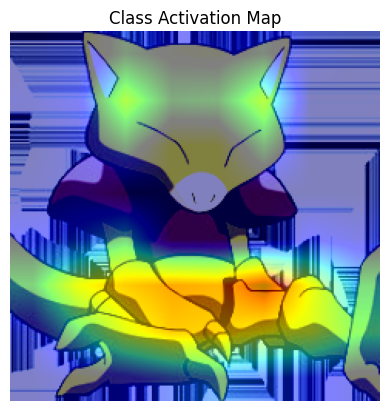

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3585434].


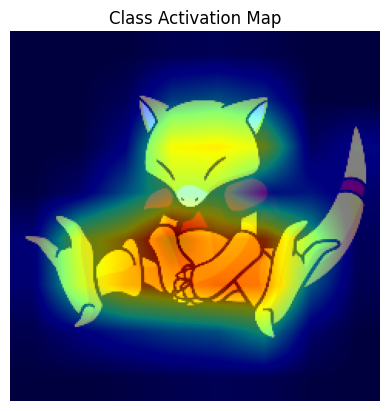

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6301525..2.64].


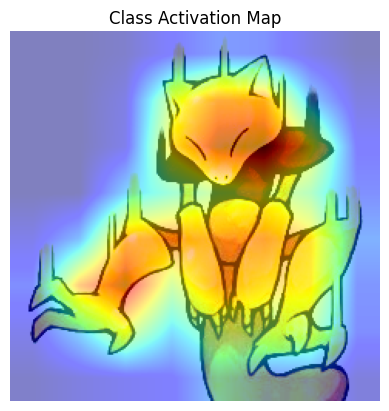

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6155462..2.64].


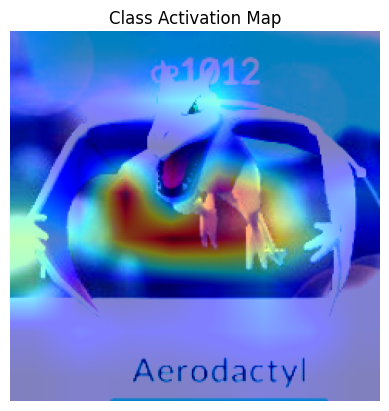

In [110]:
image_tensor, label = next(iter(val_loader))
image_tensor, label = image_tensor.to(device), label.to(device)
print(len(image_tensor))
for i in range(batch_size):
    input = image_tensor[i].unsqueeze(0)
    cam= generate_cam(model2,input)
    show_cam(input,cam)

### Assignment 12
While CAM only allows us to visualize the layer connected to the global average pooling, GradCAM allows to visualize any layers. So try to visualize other layers as well by using GradCAM. You can do some search for the GradCAM code and use it.

In [111]:
def register_gradcam_hooks(model, target_layer_name):
    activations = []
    gradients = []

    # Helper to get the correct layer from a string like "features.7.1.conv2"
    def get_target_layer(model, layer_name):
        module = model
        for i in layer_name.split('.'):
            if hasattr(module, i):
                module = getattr(module, i)
            elif i.isdigit():
                module = module[int(i)]
            else:
                raise AttributeError(f"{module} has no attribute or index {i}")
        return module

    target_layer = get_target_layer(model, target_layer_name)

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    return activations, gradients, fh, bh

def gradcam(
    model, input_tensor, target_layer_name='features.7.1.conv2', class_id=None
):
    model.eval()
    activations, gradients, fh, bh = register_gradcam_hooks(model, target_layer_name)

    output = model(input_tensor)
    if class_id is None:
        class_id = output.argmax(dim=1).item()
    model.zero_grad()
    class_score = output[0, class_id]
    class_score.backward()

    if not activations or not gradients:
        fh.remove()
        bh.remove()
        raise RuntimeError("Gradients or activations not captured properly. Check hooks and layer selection.")

    activation = activations[0]
    gradient = gradients[0]
    weights = gradient.mean(dim=(2, 3), keepdim=True)
    gradcam = (weights * activation).sum(dim=1, keepdim=True)
    gradcam = F.relu(gradcam)
    gradcam = gradcam.squeeze().cpu().numpy()
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / (gradcam.max() + 1e-6)

    # Remove hooks to avoid memory leaks
    fh.remove()
    bh.remove()
    return gradcam.astype('float32')

In [112]:
def show_gradcam(input_tensor, gradcam_map):
    # Prepare input image for plotting (assuming [C, H, W] or [1, C, H, W])
    img = input_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()

    # Prepare gradcam map for overlay
    if isinstance(gradcam_map, torch.Tensor):
        gradcam_map = gradcam_map.detach().cpu().numpy()
    gradcam_map = gradcam_map.astype(np.float32)
    if gradcam_map.ndim == 3:
        gradcam_map = gradcam_map.squeeze()
    # Resize gradcam to img spatial size
    gradcam_tensor = torch.from_numpy(gradcam_map).unsqueeze(0).unsqueeze(0).float()
    gradcam_tensor = F.interpolate(gradcam_tensor, size=img.shape[:2], mode="bilinear", align_corners=False)
    gradcam_overlay = gradcam_tensor.squeeze().cpu().numpy()

    # Overlay and save
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.imshow(gradcam_overlay, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Class Activation Map")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3585434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6301525..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6155462..2.64].


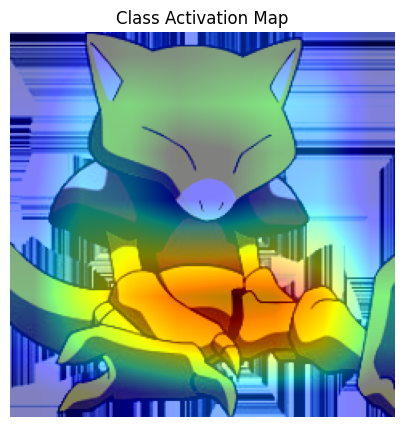

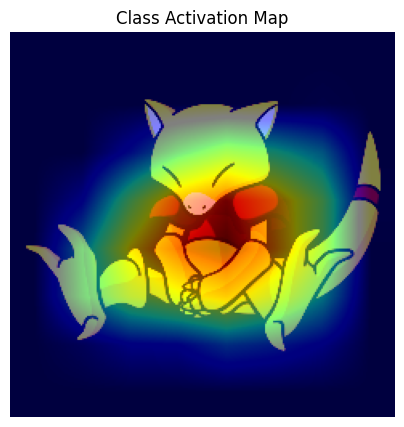

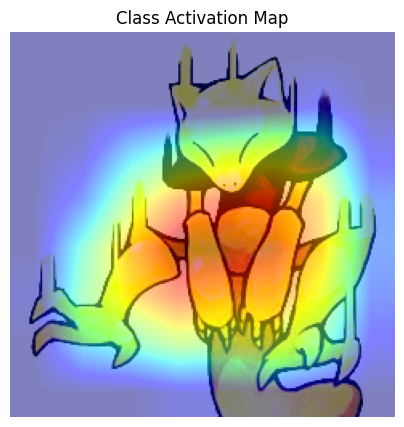

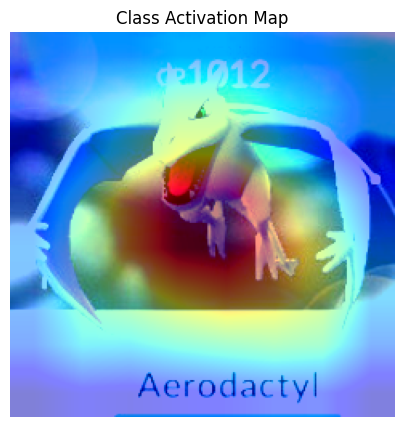

In [113]:
images, labels = next(iter(val_loader))
image_tensor, label = image_tensor.to(device), label.to(device)
for i in range(batch_size):
    input = image_tensor[i].unsqueeze(0).to(device)
    cam_map = gradcam(model2,input, target_layer_name = 'features.7.2.conv2')
    show_gradcam(input, cam_map)

### Assignment 13
Do whatever in order to get, for example
- the highest accuracy
- Any ideas
- Whatever

In [114]:
batch_size = 36
stats = [(0.485, 0.456, 0.406), (0.229,0.224,0.225)]
epochs = 10 # Difference from the model0

In [115]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p= 0.5),
    transforms.RandomVerticalFlip(p = 0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.RandomRotation(30),
    transforms.Resize((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(stats[0],stats[1])
])

test_transform = transforms.Compose([
    transforms.Resize((240,240)),
    transforms.CenterCrop(224),  # Center crop to match train size
    transforms.ToTensor(),
    transforms.Normalize(stats[0],stats[1])
])

In [116]:
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), transform= train_transform)
val_data = datasets.ImageFolder(os.path.join(data_dir,'val'), transform=test_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir,'test'),transform=test_transform)

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

class_name = train_data.classes
num_classes = len(class_name)

print(f'Num classes: {num_classes}')
print(class_name)
print(f'Training images available: {len(train_data)}')
print(f'Test images available: {len(test_data)}')

Num classes: 150
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk'

In [117]:
class CAMresnet34(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2,
            base_model.layer3,
            base_model.layer4,
        )
        self.gap = base_model.avgpool
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        self.feature_maps = x
        x = self.gap(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return F.log_softmax(x,dim = 1)
    
model2 = CAMresnet34()
model2.to(device)

CAMresnet34(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [118]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001,weight_decay= 1e-5) # L2 regularization
schedule = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma = 0.1)

In [119]:
# Train model
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def train(model,epochs, train_loader, val_loader = None):
    model.train()
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    for i in range(epochs):
        trn_corr = 0
        val_corr = 0
        tst_corr = 0
        train_loss = 0
        for b,(X_train, y_train) in enumerate(train_loader): # Training batches
            b = b+1
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss = train_loss + loss.item()
            _,preds = torch.max(y_pred, dim= 1) # Tracking correct predictions
            batch_corr = torch.sum(preds == y_train)
            trn_corr = trn_corr + batch_corr
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()
        schedule.step()

            ## Printing epoch and loss results
        if b%100 == 0:
            print(f'EPOCH: {i} LOSS: {loss.item():10.8f}')
        train_losses.append(train_loss)
        train_correct.append(trn_corr)

        # Testing batches
        loss = 0
        if val_loader:
            with torch.no_grad():
                for b,(X_val, y_val) in enumerate(val_loader):
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    y_pred = model(X_val)

                    predicted = torch.max(y_pred.data,1)[1] # Tracking correct predictions
                    val_corr = val_corr + (predicted ==y_val).sum()
                    loss = loss + criterion(y_pred,y_val)
            print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')
            val_losses.append(loss)
            val_correct.append(val_corr)
            print(f"EPOCH: {epochs} - VAL LOSS:{loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item()/len(val_loader.dataset):.4f}")
            print(f'\nDuration:{((time.time()-start_time)/60):.3f} minutes')

In [120]:
train(model2,epochs,train_loader,val_loader)
torch.save(model2.state_dict(),'PokemonModel.pt')


Validation Accuracy: 0.3105691056910569 minutes
EPOCH: 10 - VAL LOSS:0.0853, VAL_ACCURACY: 0.3106

Duration:1.278 minutes

Validation Accuracy: 0.3934959349593496 minutes
EPOCH: 10 - VAL LOSS:0.0828, VAL_ACCURACY: 0.3935

Duration:2.613 minutes

Validation Accuracy: 0.43089430894308944 minutes
EPOCH: 10 - VAL LOSS:0.0759, VAL_ACCURACY: 0.4309

Duration:3.952 minutes

Validation Accuracy: 0.5056910569105691 minutes
EPOCH: 10 - VAL LOSS:0.0725, VAL_ACCURACY: 0.5057

Duration:5.230 minutes

Validation Accuracy: 0.5398373983739837 minutes
EPOCH: 10 - VAL LOSS:0.0732, VAL_ACCURACY: 0.5398

Duration:6.881 minutes

Validation Accuracy: 0.5707317073170731 minutes
EPOCH: 10 - VAL LOSS:0.0681, VAL_ACCURACY: 0.5707

Duration:8.448 minutes

Validation Accuracy: 0.5821138211382114 minutes
EPOCH: 10 - VAL LOSS:0.0684, VAL_ACCURACY: 0.5821

Duration:9.864 minutes

Validation Accuracy: 0.6341463414634146 minutes
EPOCH: 10 - VAL LOSS:0.0618, VAL_ACCURACY: 0.6341

Duration:11.254 minutes

Validation Ac

In [121]:
def register_gradcam_hooks(model, target_layer_name):
    activations = []
    gradients = []

    # Helper to get the correct layer from a string like "features.7.1.conv2"
    def get_target_layer(model, layer_name):
        module = model
        for i in layer_name.split('.'):
            if hasattr(module, i):
                module = getattr(module, i)
            elif i.isdigit():
                module = module[int(i)]
            else:
                raise AttributeError(f"{module} has no attribute or index {i}")
        return module

    target_layer = get_target_layer(model, target_layer_name)

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    return activations, gradients, fh, bh

def gradcam(
    model, input_tensor, target_layer_name='features.7.1.conv2', class_id=None
):
    model.eval()
    activations, gradients, fh, bh = register_gradcam_hooks(model, target_layer_name)

    output = model(input_tensor)
    if class_id is None:
        class_id = output.argmax(dim=1).item()
    model.zero_grad()
    class_score = output[0, class_id]
    class_score.backward()

    if not activations or not gradients:
        fh.remove()
        bh.remove()
        raise RuntimeError("Gradients or activations not captured properly. Check hooks and layer selection.")

    activation = activations[0]
    gradient = gradients[0]
    weights = gradient.mean(dim=(2, 3), keepdim=True)
    gradcam = (weights * activation).sum(dim=1, keepdim=True)
    gradcam = F.relu(gradcam)
    gradcam = gradcam.squeeze().cpu().numpy()
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / (gradcam.max() + 1e-6)

    # Remove hooks to avoid memory leaks
    fh.remove()
    bh.remove()
    return gradcam.astype('float32')

In [122]:
def show_gradcam(input_tensor, gradcam_map):
    # Prepare input image for plotting (assuming [C, H, W] or [1, C, H, W])
    img = input_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()

    # Prepare gradcam map for overlay
    if isinstance(gradcam_map, torch.Tensor):
        gradcam_map = gradcam_map.detach().cpu().numpy()
    gradcam_map = gradcam_map.astype(np.float32)
    if gradcam_map.ndim == 3:
        gradcam_map = gradcam_map.squeeze()
    # Resize gradcam to img spatial size
    gradcam_tensor = torch.from_numpy(gradcam_map).unsqueeze(0).unsqueeze(0).float()
    gradcam_tensor = F.interpolate(gradcam_tensor, size=img.shape[:2], mode="bilinear", align_corners=False)
    gradcam_overlay = gradcam_tensor.squeeze().cpu().numpy()

    # Overlay and save
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.imshow(gradcam_overlay, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Class Activation Map")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3585434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6301525..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6155462..2.64].


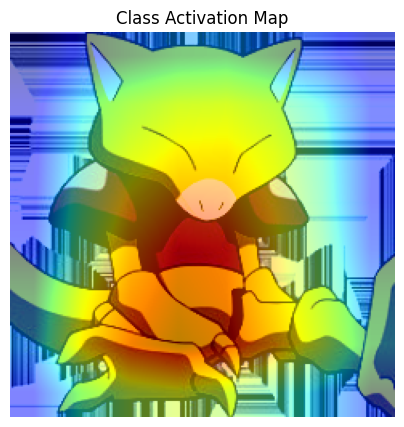

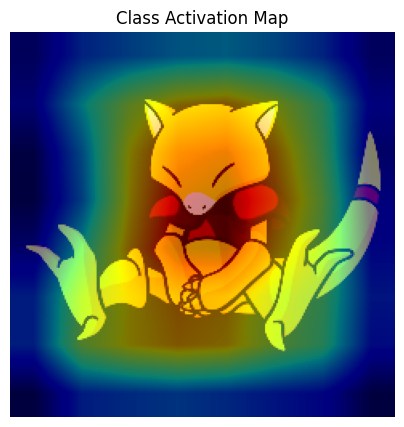

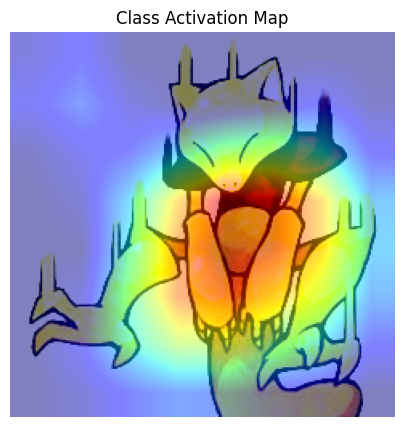

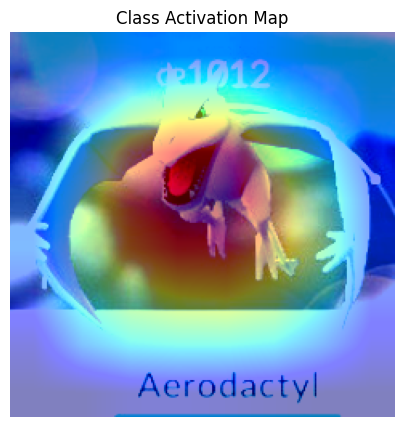

In [123]:
images, labels = next(iter(val_loader))
image_tensor, label = image_tensor.to(device), label.to(device)
for i in range(4):
    input = image_tensor[i].unsqueeze(0).to(device)
    cam_map = gradcam(model2,input, target_layer_name = 'features.7.2.conv2')
    show_gradcam(input, cam_map)

In [124]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            
            test_loss = test_loss + loss.item()
            correct = correct + (labels == predicted).sum()
    test_acc = (correct.item()/len(data_loader.dataset))*100
    print(f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item()/len(data_loader.dataset):.4f}")

In [125]:
model2 = CAMresnet34()
model2.load_state_dict(torch.load("PokemonModel.pt"))
model2.to(device)

CAMresnet34(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [126]:
test(model2,test_loader)

TEST LOSS: 0.0209, accuracy: 0.8003
